# LIBRAIRIES IMPORTATION

In [21]:
import pandas as pd
import numpy as np
import datetime
import nbformat
import wordcloud

import scipy
from scipy.optimize import curve_fit


import seaborn as sns
pal = sns.color_palette()


import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly import tools
import plotly.io as pio
import io
pio.renderers.default = "vscode"


import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
# from mpl_toolkits.basemap import Basemap

from sklearn import metrics, linear_model
from sklearn.preprocessing import  StandardScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


from IPython.display import display
from PIL import Image
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

 # FILES READING AND EDA

In [22]:
# Import dataset
print("Loading dataset...")
df = pd.read_csv("./assets/flights_usa_2019.csv")  # sep = ";"
pd.set_option('display.max_columns', None)
print("...Done.")
print()

Loading dataset...
...Done.



In [23]:
#  Merge airports list into dataframe

airports = pd.read_csv('./assets/airports_list.csv')
airports.head()

,ORIGIN_AIRPORT_ID,DISPLAY_AIRPORT_NAME,ORIGIN_CITY_NAME,NAME
0,12992,Adams Field,"Little Rock, AR","NORTH LITTLE ROCK AIRPORT, AR US"
1,10257,Albany International,"Albany, NY","ALBANY INTERNATIONAL AIRPORT, NY US"
2,10140,Albuquerque International Sunport,"Albuquerque, NM","ALBUQUERQUE INTERNATIONAL AIRPORT, NM US"
3,10299,Anchorage International,"Anchorage, AK","ANCHORAGE TED STEVENS INTERNATIONAL AIRPORT, A..."
4,10397,Atlanta Municipal,"Atlanta, GA",ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...


In [24]:
df = pd.merge(df, airports[['ORIGIN_AIRPORT_ID', 'DISPLAY_AIRPORT_NAME', 'NAME']], left_on='ORIGIN_AIRPORT_ID', right_on='ORIGIN_AIRPORT_ID')
df = pd.merge(df, airports[['ORIGIN_AIRPORT_ID', 'DISPLAY_AIRPORT_NAME', 'NAME']], left_on='DEST_AIRPORT_ID', right_on='ORIGIN_AIRPORT_ID')
df.head(3)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID_x,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME,ARR_DELAY_NEW,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 32,DISPLAY_AIRPORT_NAME_x,NAME_x,ORIGIN_AIRPORT_ID_y,DISPLAY_AIRPORT_NAME_y,NAME_y
0,1,20,7,9E,N371CA,3280,10397,ATL,"Atlanta, GA",15919,XNA,"Fayetteville, AR",1000,955.0,0.0,0.0,1000-1059,1109,1110.0,1.0,1100-1159,0.0,NaN,129.0,135.0,589.0,3,NaN,NaN,NaN,NaN,NaN,NaN,Atlanta Municipal,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,15919,Northwest Arkansas Regional,"FAYETTEVILLE SPRINGDALE NW AR REGL AIRPORT, AR US"
1,1,2,3,9E,N8928A,3329,10397,ATL,"Atlanta, GA",15919,XNA,"Fayetteville, AR",1722,1712.0,0.0,0.0,1700-1759,1830,1809.0,0.0,1800-1859,0.0,NaN,128.0,117.0,589.0,3,NaN,NaN,NaN,NaN,NaN,NaN,Atlanta Municipal,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,15919,Northwest Arkansas Regional,"FAYETTEVILLE SPRINGDALE NW AR REGL AIRPORT, AR US"
2,1,3,4,9E,N820AY,3329,10397,ATL,"Atlanta, GA",15919,XNA,"Fayetteville, AR",1722,1712.0,0.0,0.0,1700-1759,1830,1755.0,0.0,1800-1859,0.0,NaN,128.0,103.0,589.0,3,NaN,NaN,NaN,NaN,NaN,NaN,Atlanta Municipal,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,15919,Northwest Arkansas Regional,"FAYETTEVILLE SPRINGDALE NW AR REGL AIRPORT, AR US"


In [25]:
# Merge carriers list into dataframe
carriers = pd.read_csv('./assets/CARRIER_DECODE.csv')
carriers.drop_duplicates(subset=['OP_UNIQUE_CARRIER'], inplace=True)
df = pd.merge(df, carriers, on='OP_UNIQUE_CARRIER', how='left')

df.head(3)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID_x,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME,ARR_DELAY_NEW,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 32,DISPLAY_AIRPORT_NAME_x,NAME_x,ORIGIN_AIRPORT_ID_y,DISPLAY_AIRPORT_NAME_y,NAME_y,AIRLINE_ID,CARRIER_NAME
0,1,20,7,9E,N371CA,3280,10397,ATL,"Atlanta, GA",15919,XNA,"Fayetteville, AR",1000,955.0,0.0,0.0,1000-1059,1109,1110.0,1.0,1100-1159,0.0,NaN,129.0,135.0,589.0,3,NaN,NaN,NaN,NaN,NaN,NaN,Atlanta Municipal,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,15919,Northwest Arkansas Regional,"FAYETTEVILLE SPRINGDALE NW AR REGL AIRPORT, AR US",20363,Endeavor Air Inc.
1,1,2,3,9E,N8928A,3329,10397,ATL,"Atlanta, GA",15919,XNA,"Fayetteville, AR",1722,1712.0,0.0,0.0,1700-1759,1830,1809.0,0.0,1800-1859,0.0,NaN,128.0,117.0,589.0,3,NaN,NaN,NaN,NaN,NaN,NaN,Atlanta Municipal,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,15919,Northwest Arkansas Regional,"FAYETTEVILLE SPRINGDALE NW AR REGL AIRPORT, AR US",20363,Endeavor Air Inc.
2,1,3,4,9E,N820AY,3329,10397,ATL,"Atlanta, GA",15919,XNA,"Fayetteville, AR",1722,1712.0,0.0,0.0,1700-1759,1830,1755.0,0.0,1800-1859,0.0,NaN,128.0,103.0,589.0,3,NaN,NaN,NaN,NaN,NaN,NaN,Atlanta Municipal,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,15919,Northwest Arkansas Regional,"FAYETTEVILLE SPRINGDALE NW AR REGL AIRPORT, AR US",20363,Endeavor Air Inc.


In [26]:
df = df.drop([ 'ORIGIN_AIRPORT_ID_y'], axis=1)
df = df.rename(columns={'ORIGIN_CITY_NAME_x': 'ORIGIN_CITY_NAME'})
df = df.rename(columns={'ORIGIN_AIRPORT_ID_x': 'ORIGIN_AIRPORT_ID'})
df = df.rename(columns={'NAME_x': 'ORIGIN_AIRPORT_NAME'})
df = df.rename(columns={'NAME_y': 'DEST_AIRPORT_NAME'})
df = df.rename(columns={'CARRIER_NAME_x': 'CARRIER_NAME'})
df = df.rename(columns={'DISPLAY_AIRPORT_NAME_x': 'ORIGIN_DISPLAY_AIRPORT'})
df = df.rename(columns={'DISPLAY_AIRPORT_NAME_y': 'DEST_DISPLAY_AIRPORT'})

df.head(2)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME,ARR_DELAY_NEW,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 32,ORIGIN_DISPLAY_AIRPORT,ORIGIN_AIRPORT_NAME,DEST_DISPLAY_AIRPORT,DEST_AIRPORT_NAME,AIRLINE_ID,CARRIER_NAME
0,1,20,7,9E,N371CA,3280,10397,ATL,"Atlanta, GA",15919,XNA,"Fayetteville, AR",1000,955.0,0.0,0.0,1000-1059,1109,1110.0,1.0,1100-1159,0.0,NaN,129.0,135.0,589.0,3,NaN,NaN,NaN,NaN,NaN,NaN,Atlanta Municipal,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,Northwest Arkansas Regional,"FAYETTEVILLE SPRINGDALE NW AR REGL AIRPORT, AR US",20363,Endeavor Air Inc.
1,1,2,3,9E,N8928A,3329,10397,ATL,"Atlanta, GA",15919,XNA,"Fayetteville, AR",1722,1712.0,0.0,0.0,1700-1759,1830,1809.0,0.0,1800-1859,0.0,NaN,128.0,117.0,589.0,3,NaN,NaN,NaN,NaN,NaN,NaN,Atlanta Municipal,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,Northwest Arkansas Regional,"FAYETTEVILLE SPRINGDALE NW AR REGL AIRPORT, AR US",20363,Endeavor Air Inc.


Select 10% of the lines randomly because the datset is too large (almost 10 million lines)

In [27]:
# Sélectionner 10% des lignes au hasard

random_indices = np.random.choice(df.index, size=int(len(df)*0.1), replace=False)
sampled_df = df.loc[random_indices]

# Order by month
sampled_df = sampled_df.sort_values('MONTH')

# export in csv
# sampled_df.to_csv("echantillon_df_10%.csv", index=False)

In [28]:
sampled_df.head(3)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME,ARR_DELAY_NEW,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 32,ORIGIN_DISPLAY_AIRPORT,ORIGIN_AIRPORT_NAME,DEST_DISPLAY_AIRPORT,DEST_AIRPORT_NAME,AIRLINE_ID,CARRIER_NAME
2313100,1,16,3,AA,N830AW,1631,11057,CLT,"Charlotte, NC",13495,MSY,"New Orleans, LA",1815,1809.0,0.0,0.0,1800-1859,1927,1911.0,0.0,1900-1959,0.0,NaN,132.0,122.0,651.0,3,NaN,NaN,NaN,NaN,NaN,NaN,Douglas Municipal,"CHARLOTTE DOUGLAS AIRPORT, NC US",Louis Armstrong New Orleans International,"NEW ORLEANS AIRPORT, LA US",19805,American Airlines Inc.
7165221,1,25,5,DL,N918DE,2114,11267,DAY,"Dayton, OH",10397,ATL,"Atlanta, GA",600,552.0,0.0,0.0,0600-0659,746,802.0,16.0,0700-0759,0.0,NaN,106.0,130.0,432.0,2,0.0,0.0,16.0,0.0,0.0,NaN,James M Cox/Dayton International,"DAYTON WRIGHT BROTHERS AIRPORT, OH US",Atlanta Municipal,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,19790,Delta Air Lines Inc.
5790417,1,24,4,YV,N85358,6115,11423,DSM,"Des Moines, IA",12266,IAH,"Houston, TX",615,608.0,0.0,0.0,0600-0659,855,844.0,0.0,0800-0859,0.0,NaN,160.0,156.0,802.0,4,NaN,NaN,NaN,NaN,NaN,NaN,Des Moines Municipal,"DES MOINES INTERNATIONAL AIRPORT, IA US",Honolulu International,"HONOLULU INTERNATIONAL AIRPORT, HI US",20378,Mesa Airlines Inc.


In [29]:
sampled_df.shape

(763620, 39)

In [30]:
# Basic stats
print("Number of rows : {}".format(sampled_df.shape[0]))
print()

print("Display of dataset: ")
display(sampled_df.head())
print()

print("Basics statistics: ")
data_desc = sampled_df.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")

pd.concat([sampled_df.isnull().sum(), 100 * sampled_df.isnull().sum()/len(sampled_df)], axis=1).rename(columns={0:'Missing Records', 1:'Percentage (%)'})


Number of rows : 763620

Display of dataset: 


,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME,ARR_DELAY_NEW,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 32,ORIGIN_DISPLAY_AIRPORT,ORIGIN_AIRPORT_NAME,DEST_DISPLAY_AIRPORT,DEST_AIRPORT_NAME,AIRLINE_ID,CARRIER_NAME
2313100,1,16,3,AA,N830AW,1631,11057,CLT,"Charlotte, NC",13495,MSY,"New Orleans, LA",1815,1809.0,0.0,0.0,1800-1859,1927,1911.0,0.0,1900-1959,0.0,NaN,132.0,122.0,651.0,3,NaN,NaN,NaN,NaN,NaN,NaN,Douglas Municipal,"CHARLOTTE DOUGLAS AIRPORT, NC US",Louis Armstrong New Orleans International,"NEW ORLEANS AIRPORT, LA US",19805,American Airlines Inc.
7165221,1,25,5,DL,N918DE,2114,11267,DAY,"Dayton, OH",10397,ATL,"Atlanta, GA",600,552.0,0.0,0.0,0600-0659,746,802.0,16.0,0700-0759,0.0,NaN,106.0,130.0,432.0,2,0.0,0.0,16.0,0.0,0.0,NaN,James M Cox/Dayton International,"DAYTON WRIGHT BROTHERS AIRPORT, OH US",Atlanta Municipal,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,19790,Delta Air Lines Inc.
5790417,1,24,4,YV,N85358,6115,11423,DSM,"Des Moines, IA",12266,IAH,"Houston, TX",615,608.0,0.0,0.0,0600-0659,855,844.0,0.0,0800-0859,0.0,NaN,160.0,156.0,802.0,4,NaN,NaN,NaN,NaN,NaN,NaN,Des Moines Municipal,"DES MOINES INTERNATIONAL AIRPORT, IA US",Honolulu International,"HONOLULU INTERNATIONAL AIRPORT, HI US",20378,Mesa Airlines Inc.
1970586,1,6,7,WN,N8618N,1385,13796,OAK,"Oakland, CA",13204,MCO,"Orlando, FL",955,1000.0,5.0,0.0,0900-0959,1800,1759.0,0.0,1800-1859,0.0,NaN,305.0,299.0,2438.0,10,NaN,NaN,NaN,NaN,NaN,NaN,Metropolitan Oakland International,"SACRAMENTO METROPOLITAN AIRPORT, CA US",Orlando International,"ORLANDO INTERNATIONAL AIRPORT, FL US",19393,Southwest Airlines Co.
1268149,1,23,3,DL,N328DN,2886,14869,SLC,"Salt Lake City, UT",12889,LAS,"Las Vegas, NV",820,819.0,0.0,0.0,0800-0859,905,842.0,0.0,0900-0959,0.0,NaN,105.0,83.0,368.0,2,NaN,NaN,NaN,NaN,NaN,NaN,Salt Lake City International,"SALT LAKE CITY INTERNATIONAL AIRPORT, UT US",McCarran International,"MCCARRAN INTERNATIONAL AIRPORT, NV US",19790,Delta Air Lines Inc.



Basics statistics: 


,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME,ARR_DELAY_NEW,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 32,ORIGIN_DISPLAY_AIRPORT,ORIGIN_AIRPORT_NAME,DEST_DISPLAY_AIRPORT,DEST_AIRPORT_NAME,AIRLINE_ID,CARRIER_NAME
count,763620.000000,763620.000000,763620.000000,763620,761669,763620.000000,763620.000000,763620,763620,763620.000000,763620,763620,763620.000000,750475.000000,750475.000000,750475.000000,763620,763620.000000,749770.000000,748108.000000,763620,763620.000000,13641,763616.000000,748108.000000,763620.000000,763620.000000,145836.000000,145836.000000,145836.000000,145836.000000,145836.000000,0.0,763620,763620,763620,763620,763620.000000,763620
unique,NaN,NaN,NaN,17,5840,NaN,NaN,97,93,NaN,97,93,NaN,NaN,NaN,NaN,19,NaN,NaN,NaN,19,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97,86,97,86,NaN,17
top,NaN,NaN,NaN,WN,N480HA,NaN,NaN,ATL,"Chicago, IL",NaN,ATL,"Chicago, IL",NaN,NaN,NaN,NaN,0600-0659,NaN,NaN,NaN,2100-2159,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Atlanta Municipal,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",Atlanta Municipal,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",NaN,Southwest Airlines Co.
freq,NaN,NaN,NaN,165522,392,NaN,NaN,37629,44820,NaN,37981,44772,NaN,NaN,NaN,NaN,56052,NaN,NaN,NaN,49210,NaN,6663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37629,44820,37981,44772,NaN,165522
mean,6.536415,15.747598,3.916981,NaN,NaN,2293.476665,12716.547796,NaN,NaN,12716.974465,NaN,NaN,1330.544398,1334.349160,14.315677,0.193344,NaN,1485.528838,1459.792699,14.262025,NaN,0.017864,NaN,151.011009,145.505251,875.587642,3.971577,20.436573,3.336536,17.331551,0.081043,26.911435,NaN,NaN,NaN,NaN,NaN,19920.762145,NaN
std,3.130913,8.775128,1.994985,NaN,NaN,1699.472742,1515.079546,NaN,NaN,1515.510244,NaN,NaN,495.648190,511.051347,46.702152,0.394921,NaN,529.438483,552.095666,46.471377,NaN,0.132456,NaN,74.923563,75.225277,615.778145,2.417915,61.959886,28.592471,40.892874,2.294878,52.703119,NaN,NaN,NaN,NaN,NaN,364.830855,NaN
min,1.000000,1.000000,1.000000,NaN,NaN,1.000000,10140.000000,NaN,NaN,10140.000000,NaN,NaN,1.000000,1.000000,0.000000,0.000000,NaN,1.000000,1.000000,0.000000,NaN,0.000000,NaN,32.000000,27.000000,67.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,19393.000000,NaN
25%,4.000000,8.000000,2.000000,NaN,NaN,887.000000,11292.000000,NaN,NaN,11292.000000,NaN,NaN,905.000000,907.000000,0.000000,0.000000,NaN,1057.000000,1041.000000,0.000000,NaN,0.000000,NaN,95.000000,90.000000,414.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,19790.000000,NaN
50%,7.000000,16.000000,4.000000,NaN,NaN,1915.000000,12892.000000,NaN,NaN,12892.000000,NaN,NaN,1322.000000,1326.000000,0.000000,0.000000,NaN,1517.000000,1503.000000,0.000000,NaN,0.000000,NaN,133.000000,128.000000,721.000000,3.000000,0.000000,0.000000,2.000000,0.000000,2.000000,NaN,NaN,NaN,NaN,NaN,19805.000000,NaN
75%,9.000000,23.000000,6.000000,NaN,NaN,3429.000000,14057.000000,NaN,NaN,14057.000000,NaN,NaN,1740.000000,1749.000000,8.000000,0.000000,NaN,1925.000000,1921.000000,8.000000,NaN,0.000000,NaN,181.000000,177.000000,1108.000000,5.000000,18.000000,0.000000,20.000000,0.000000,33.000000,NaN,NaN,NaN,NaN,NaN,20314.000000,NaN



Percentage of missing values: 


,Missing Records,Percentage (%)
MONTH,0,0.000000
DAY_OF_MONTH,0,0.000000
DAY_OF_WEEK,0,0.000000
OP_UNIQUE_CARRIER,0,0.000000
TAIL_NUM,1951,0.255494
OP_CARRIER_FL_NUM,0,0.000000
ORIGIN_AIRPORT_ID,0,0.000000
ORIGIN,0,0.000000
ORIGIN_CITY_NAME,0,0.000000
DEST_AIRPORT_ID,0,0.000000


In [31]:
print('List of columns:')
list_columns = list(sampled_df.columns)
print(list(sampled_df.columns))
print(f'Total: {len(list(sampled_df.columns))} columns')


List of columns:
['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'DEST_AIRPORT_ID', 'DEST', 'DEST_CITY_NAME', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_TIME_BLK', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY_NEW', 'ARR_TIME_BLK', 'CANCELLED', 'CANCELLATION_CODE', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'DISTANCE', 'DISTANCE_GROUP', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'Unnamed: 32', 'ORIGIN_DISPLAY_AIRPORT', 'ORIGIN_AIRPORT_NAME', 'DEST_DISPLAY_AIRPORT', 'DEST_AIRPORT_NAME', 'AIRLINE_ID', 'CARRIER_NAME']
Total: 39 columns


In [32]:
# plotting departure airports for better visualization

# colors = sns.color_palette("colorblind", len(years))
colors = pal

df_airport = sampled_df['ORIGIN_AIRPORT_NAME'].value_counts()[:10]
label = df_airport.index
size = df_airport.values

trace = go.Pie(labels=label, values=size, marker=dict(colors=colors),hole = .2)

data = [trace]
layout = go.Layout(
    title='Flights Origin Airport'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

D'après le graphique ci-dessus, nous savons que l'aéroport international de Chicago O'Hare est le plus fréquenté en 2019, suivi de l'aéroport international d'Atlanta Hartsfield.

In [33]:
# plotting departure city

sampled_df_c = sampled_df.ORIGIN_CITY_NAME.value_counts()[:10]

trace = go.Bar(
    x=sampled_df_c.index,
    y=sampled_df_c.values,
    marker=dict(
        color = sampled_df_c.values,
        colorscale='Jet',
        showscale=True
    )
)

data = [trace]
layout = go.Layout(
    title='Origin City Distribution', 
    yaxis = dict(title = 'Number of Flights')
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

La barre de répartition ci-dessus montre que la plupart des vols partent de Chicago (plus 500 000 vols vu qu'on a prelevé 10% du dataset) et sont suivis par Atlanta.

In [34]:
df_airline = sampled_df.CARRIER_NAME.value_counts()[:10]

trace = go.Bar(
    x=df_airline.index,
    y=df_airline.values,
    marker=dict(
        color = df_airline.values,
        colorscale='Jet',
        showscale=True)
)

data = [trace]
layout = go.Layout(xaxis=dict(tickangle=15),
    title='Airline distribution', 
                   yaxis = dict(title = 'Number of Flights'))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

D'après le tableau ci-dessus, la compagnie aérienne la plus empruntée en 2019 est Southwest Airlines, suivi de American Airlines.

In [35]:
# Monthly flight traffic during the year

months = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May',6: 'Jun' , 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df_m = sampled_df.MONTH.value_counts().to_frame().reset_index(names='index').sort_values(by='index')
df_m.columns = ['MONTH', 'FlightNum']
df_m.MONTHS = df_m.MONTH.map(months)

trace = go.Bar(
    x=df_m.MONTHS,
    y=df_m.FlightNum,
    marker=dict(
        color = df_m.FlightNum,
        colorscale='Reds',
        showscale=True)
)

data = [trace]
layout = go.Layout(
    title='Number of Flights (monthly)', 
    yaxis = dict(title = 'Number of Flights'
                                                )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

C:\Users\galus\AppData\Local\Temp\ipykernel_19908\2892100490.py:6: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



La barre de distribution ci-dessus fournit des informations sur le nombre de vols par mois en 2019. Les plus élevés sont ceux de avril, juillet et aout. Par contre si nous comparons avec les autres mois, il n'y a pas de differnce de nombre de vols significative.

In [36]:
# Daily flight traffic during the year

days={1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday', 7:'Sunday'}
df_d = sampled_df.DAY_OF_WEEK.value_counts().to_frame().reset_index(names='index').sort_values(by='index')
df_d.columns = ['DAY_OF_WEEK', 'FlightNum']
df_d.DAY_OF_WEEK = df_d.DAY_OF_WEEK.map(days)

trace1 = go.Bar(
    x=df_d.DAY_OF_WEEK,
    y=df_d.FlightNum,
    marker=dict(
        color = df_d.FlightNum,  
        showscale=True
    )
)

data = [trace1]
layout = go.Layout(
    title='# of Flights (Day of Week)', 
    yaxis = dict(title = 'Number of Flights'
  )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Selon le graphique ci-dessus, du lundi au vendredi, le nombre de vols est similaire et le plus bas est le samedi

In [37]:
# Percentage of delay per month

sampled_df['DEP_DELAY'] = np.where(sampled_df.DEP_DELAY_NEW>0,1,0)
sampled_df['ARR_DELAY'] = np.where(sampled_df.ARR_DELAY_NEW>0,1,0)
df_m = sampled_df.groupby('MONTH').DEP_DELAY_NEW.mean().round(2)

df_m.index = df_m.index.map(months)
trace1 = go.Bar(
    x=df_m.index,
    y=df_m.values,
    name = 'Departure_delay',
    marker = dict(
        color = 'green'
    )
)

df_m = sampled_df.groupby('MONTH').ARR_DELAY_NEW.mean().round(2)
df_m.index = df_m.index.map(months)

trace2 = go.Bar(
    x=df_m.index,
    y=df_m.values,
    name='Arrival_delay',
    marker=dict(
        color = 'red'
    )
)

data = [trace1,trace2]
layout = go.Layout(
    title='% Delay (Months)', 
    yaxis = dict(title = '%')
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Selon le tableau ci-dessus, le retard d'arrivée est supérieur à celui du retard de départ. On l'observe en juin oû on a enregistré le plus grand nombre de retard.

In [38]:
# Percentage of delay per month

df_d = sampled_df.groupby('DAY_OF_WEEK').DEP_DELAY_NEW.mean().round(2)
df_d.index = df_d.index.map(days)

trace1 = go.Bar(
    x=df_d.index,
    y=df_d.values,
    name = 'Departure_delay',
    marker=dict(
        color = 'cyan'
    )
)

df_d = sampled_df.groupby('DAY_OF_WEEK').ARR_DELAY_NEW.mean().round(2)
df_d.index = df_d.index.map(days)

trace2 = go.Bar(
    x=df_d.index,
    y=df_d.values,
    name='Arrival_delay',
    marker=dict(
        color = 'indigo'
    )
)

data = [trace1,trace2]
layout = go.Layout(
    title='% Delay (Day of Week)', 
    yaxis = dict(title = '%')
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Selon le graphique ci-dessus, la plupart des retards se sont produits le jeudi, le vendredi et le dimanche. Cependant, à la différence du mois où le nombre de retards d'arrivée est supérieur au retard de départ, lorsque nous comparons par jour de la semaine, le nombre de retards de départ est supérieur à celui du retard d'arrivée.

In [39]:
print(list_columns)

['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'DEST_AIRPORT_ID', 'DEST', 'DEST_CITY_NAME', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_TIME_BLK', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY_NEW', 'ARR_TIME_BLK', 'CANCELLED', 'CANCELLATION_CODE', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'DISTANCE', 'DISTANCE_GROUP', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'Unnamed: 32', 'ORIGIN_DISPLAY_AIRPORT', 'ORIGIN_AIRPORT_NAME', 'DEST_DISPLAY_AIRPORT', 'DEST_AIRPORT_NAME', 'AIRLINE_ID', 'CARRIER_NAME']


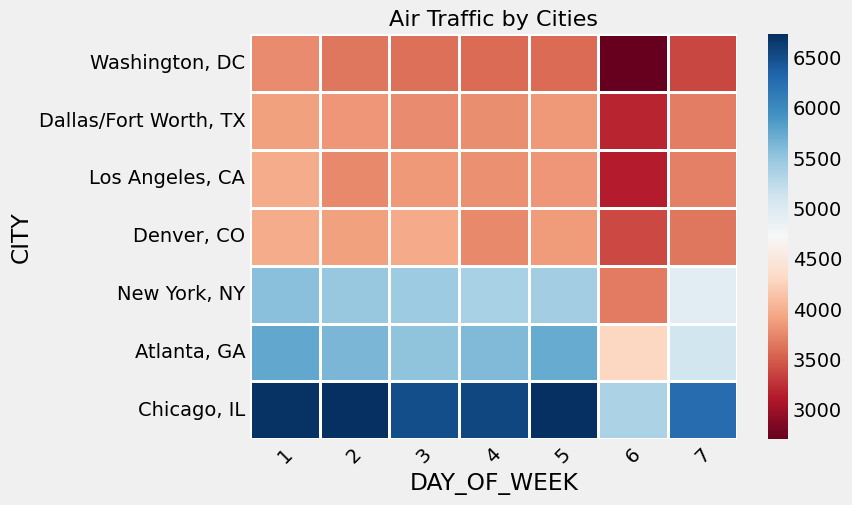

In [40]:
# Air traffic by city 

flight_volume = sampled_df.pivot_table(index="ORIGIN_CITY_NAME",columns="DAY_OF_WEEK",values="DAY_OF_MONTH",aggfunc=lambda x:x.count())
fv = flight_volume.sort_values(by=1, ascending=False)[:7]
fv = fv.iloc[::-1]

fig = plt.figure(figsize=(7, 5))
sns.heatmap(fv, cmap='RdBu',linecolor="w", linewidths=2)

plt.title('Air Traffic by Cities',size=16)
plt.ylabel('CITY')
plt.xticks(rotation=45)
plt.show()

D'après la carte ci-dessus, nous apprenons que samedi, de nombreuses personnes à Atlanta et à Chicago préfèrent ne pas quitter leur ville. Différent des autres villes où la plupart de leurs habitants choisissent de partir le samedi.

In [41]:
# Airlines comparison

df_a = sampled_df.groupby('CARRIER_NAME').DEP_DELAY_NEW.mean().to_frame().sort_values(by='DEP_DELAY_NEW', ascending=False).round(2)
trace1 = go.Bar(
    x=df_a.index,
    y=df_a.DEP_DELAY_NEW,
    name='Departure_delay',
    marker=dict(
        color = 'yellow'
    )
)

df_a = sampled_df.groupby('CARRIER_NAME').ARR_DELAY_NEW.mean().to_frame().sort_values(by='ARR_DELAY_NEW', ascending=False).round(2)
trace2 = go.Bar(
    x=df_a.index,
    y=df_a.ARR_DELAY_NEW,
    name='Arrival_delay',
    marker=dict(
        color = 'orange'
    )
)

data = [trace1, trace2]
layout = go.Layout(xaxis=dict(tickangle=15), title='Mean Arrival & Departure Delay by Airlines',
    yaxis = dict(title = 'minute'), 
                   barmode='stack')

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [42]:
sampled_df['DEP_ARR_DIFF'] = sampled_df['DEP_DELAY_NEW'] - sampled_df['ARR_DELAY_NEW']
df_dif = sampled_df.groupby('CARRIER_NAME').DEP_ARR_DIFF.mean().to_frame().sort_values(by='DEP_ARR_DIFF', ascending=False).round(2)

trace = go.Bar(
    x=df_dif.index,
    y=df_dif.DEP_ARR_DIFF,
    marker=dict(
        color = df_dif.DEP_ARR_DIFF,
        colorscale='Jet',
        showscale=True
    )
)

data = [trace]
layout = go.Layout(xaxis=dict(tickangle=15),
    title='Mean (Departure Delay - Arrival Delay) by Airlines', 
                   yaxis = dict(title = 'minute')
                  )

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Nous pouvons voir qu'il y a plusieurs compagnies aériennes dont le nombre de retards à l'arrivée est supérieur à celui du retard au départ comme : American Eagle Airlines ou encore Midwest Airline.

In [43]:
# Cancellation rates by airlines

df_c = sampled_df.groupby('CARRIER_NAME')[['CANCELLED']].mean().sort_values(by='CANCELLED', ascending=False).round(3)

trace1 = go.Scatter(
    x=df_c.index,
    y=df_c.CANCELLED,
    mode='markers',
    marker=dict(
        symbol = 'star-square',
        sizemode = 'diameter',
        sizeref = 1,
        size = 20,
        color = df_c.CANCELLED,
        colorscale='Portland',
        showscale=True
    )
)

data = [trace1]
layout = go.Layout(xaxis=dict(tickangle=20),
    title='Cancellation Rate by Airlines', yaxis = dict(title = 'Cancellation Rate')
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="age")

df_c = df.groupby('ORIGIN_CITY_NAME')[['CANCELLED']].mean().sort_values(by='CANCELLED', ascending=False)[:10].round(3)
trace2 = go.Scatter(
    x=df_c.index,
    y=df_c.CANCELLED,
        mode='markers',
        marker=dict(symbol = 'diamond',
        sizemode = 'diameter',
        sizeref = 1,
        size = 20,
        color = df_c.CANCELLED,
        colorscale='Portland',
        showscale=True
    )
)

data = [trace2]
layout = go.Layout(xaxis=dict(tickangle=20),
    title='Cancellation Rate by Cities', 
 yaxis = dict(title = 'Cancellation Rate' )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

American Eagle Airlines et Atlantic Southeast Airlines sont aussi les compagnies aériennes avec le taux d'annulation le plus élevé. De plus, si on compare par ville, Burbank est la ville avec le taux d'annulation le plus élevé suivi de Dallas. Les plus bas sont Grand Rapids et Buffalo.

In [44]:
# Correlation Matrix

import plotly.graph_objs as go
import numpy as np

# Création d'un tableau de données aléatoires pour illustrer l'exemple
correlation = sampled_df[['DAY_OF_WEEK','MONTH','ACTUAL_ELAPSED_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY_NEW']].fillna(0).corr()
cols = correlation.columns.values
corr  = correlation.values

# Création d'un Heatmap avec les données
trace = go.Heatmap(z=corr,
                   x=cols,
                   y=cols,
                   reversescale=True)

# Ajout des annotations de texte à l'intérieur du Heatmap
annotations = []
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        annotations.append(dict(x=cols[j], y=cols[i], text='{:.2f}'.format(corr[i, j]), font=dict(color='white'), showarrow=False))

# Configuration du layout
layout = go.Layout(dict(title="Correlation Matrix for variables",
                        autosize=False,
                        height=600,
                        width=800,
                        margin=dict(l=200),
                        yaxis=dict(tickfont=dict(size=8)),
                        xaxis=dict(tickfont=dict(size=8)),
                        annotations=annotations))

# Création de la figure avec le Heatmap et le layout
fig = go.Figure(data=[trace], layout=layout)

# Affichage de la figure
fig.show()


Selon la carte thermique, DISTANCE, ACTUAL_ELAPSED_TIME et CRS_ELAPSED_TIME ont une corrélation élevée et ARR_TIME a une corrélation élevée avec CRS_ARR_TIME.

# CLEANING

1. DATES AND TIMES

In [45]:
sampled_df['DATE'] = pd.to_datetime(sampled_df.DAY_OF_MONTH.map(str)+'-'+sampled_df.MONTH.map(str)+'-'+'2019', format='%d-%m-%Y')


In [46]:
# Définir une fonction pour formater les valeurs en heures
def format_hour():
    if time == '' or time == 'NaN' or time == None:
        return ''
    else:
        time = int(time)
        hour = str(time // 100).zfill(2)
        minute = str(time % 100).zfill(2)
        return "{}:{}:00".format(hour, minute)

# Définir une fonction pour convertir en l'heure en secondes 
def format_seconds(time='None'):
    if time == '' or time == 'NaN' or time == None:
        return ''
    else:
        time = int(time)
        seconds = (time//100)*3600 + (time%100)*60 
        return seconds


In [47]:
# We collect only the columns that will be used

sampled_df = sampled_df[['MONTH', 'OP_UNIQUE_CARRIER', 'CARRIER_NAME', 'ORIGIN_CITY_NAME', 'ORIGIN', 'DEST_CITY_NAME',  'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY_NEW', 'CRS_ARR_TIME' ,'ARR_TIME', 'DEST', 'ARR_DELAY_NEW' ,'ORIGIN_AIRPORT_NAME' , 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'DEST_AIRPORT_NAME', 'DISTANCE']]
sampled_df.head(3)

,MONTH,OP_UNIQUE_CARRIER,CARRIER_NAME,ORIGIN_CITY_NAME,ORIGIN,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,CRS_ARR_TIME,ARR_TIME,DEST,ARR_DELAY_NEW,ORIGIN_AIRPORT_NAME,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DEST_AIRPORT_NAME,DISTANCE
2313100,1,AA,American Airlines Inc.,"Charlotte, NC",CLT,"New Orleans, LA",1815,1809.0,0.0,1927,1911.0,MSY,0.0,"CHARLOTTE DOUGLAS AIRPORT, NC US",132.0,122.0,"NEW ORLEANS AIRPORT, LA US",651.0
7165221,1,DL,Delta Air Lines Inc.,"Dayton, OH",DAY,"Atlanta, GA",600,552.0,0.0,746,802.0,ATL,16.0,"DAYTON WRIGHT BROTHERS AIRPORT, OH US",106.0,130.0,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,432.0
5790417,1,YV,Mesa Airlines Inc.,"Des Moines, IA",DSM,"Houston, TX",615,608.0,0.0,855,844.0,IAH,0.0,"DES MOINES INTERNATIONAL AIRPORT, IA US",160.0,156.0,"HONOLULU INTERNATIONAL AIRPORT, HI US",802.0


In [48]:
print("Percentage of missing values: ")
pd.concat([sampled_df.isnull().sum(), 100 * sampled_df.isnull().sum()/len(sampled_df)], axis=1).rename(columns={0:'Missing Records', 1:'Percentage (%)'})

Percentage of missing values: 


,Missing Records,Percentage (%)
MONTH,0,0.000000
OP_UNIQUE_CARRIER,0,0.000000
CARRIER_NAME,0,0.000000
ORIGIN_CITY_NAME,0,0.000000
ORIGIN,0,0.000000
DEST_CITY_NAME,0,0.000000
CRS_DEP_TIME,0,0.000000
DEP_TIME,13145,1.721406
DEP_DELAY_NEW,13145,1.721406
CRS_ARR_TIME,0,0.000000


On voit que le facteur de remplissage des variables est assez bon (pratiquement 98%). on supprimer les valeurs manquantes

In [49]:
# Remplacer les valeurs manquantes par le mode ou medianne

# # Loop through each column in the DataFrame
# for column in sampled_df.columns:
#     # Check if the column contains string values
#     if sampled_df[column].dtype == 'object':
#         # Replace missing values with the mode of the column
#         sampled_df[column].fillna(sampled_df[column].mode()[0], inplace=True)
#     # Check if the column contains numeric values
#     elif sampled_df[column].dtype in ['float64', 'int64']:
#         # Replace missing values with the median of the column
#         sampled_df[column].fillna(sampled_df[column].median(), inplace=True)

sampled_df.dropna(inplace=True)

In [50]:
# Apply seconds on time

sampled_df['CRS_DEP_TIME'] = sampled_df['CRS_DEP_TIME'].apply(format_seconds)
sampled_df['DEP_TIME'] = sampled_df['DEP_TIME'].apply(format_seconds)
sampled_df['CRS_ARR_TIME'] = sampled_df['CRS_ARR_TIME'].apply(format_seconds)
sampled_df['ARR_TIME'] = sampled_df['ARR_TIME'].apply(format_seconds)

sampled_df.head(3)

,MONTH,OP_UNIQUE_CARRIER,CARRIER_NAME,ORIGIN_CITY_NAME,ORIGIN,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,CRS_ARR_TIME,ARR_TIME,DEST,ARR_DELAY_NEW,ORIGIN_AIRPORT_NAME,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DEST_AIRPORT_NAME,DISTANCE
2313100,1,AA,American Airlines Inc.,"Charlotte, NC",CLT,"New Orleans, LA",65700,65340,0.0,70020,69060,MSY,0.0,"CHARLOTTE DOUGLAS AIRPORT, NC US",132.0,122.0,"NEW ORLEANS AIRPORT, LA US",651.0
7165221,1,DL,Delta Air Lines Inc.,"Dayton, OH",DAY,"Atlanta, GA",21600,21120,0.0,27960,28920,ATL,16.0,"DAYTON WRIGHT BROTHERS AIRPORT, OH US",106.0,130.0,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,432.0
5790417,1,YV,Mesa Airlines Inc.,"Des Moines, IA",DSM,"Houston, TX",22500,22080,0.0,32100,31440,IAH,0.0,"DES MOINES INTERNATIONAL AIRPORT, IA US",160.0,156.0,"HONOLULU INTERNATIONAL AIRPORT, HI US",802.0


In [51]:
print("Percentage of missing values: ")
pd.concat([sampled_df.isnull().sum(), 100 * sampled_df.isnull().sum()/len(sampled_df)], axis=1).rename(columns={0:'Missing Records', 1:'Percentage (%)'})

Percentage of missing values: 


,Missing Records,Percentage (%)
MONTH,0,0.0
OP_UNIQUE_CARRIER,0,0.0
CARRIER_NAME,0,0.0
ORIGIN_CITY_NAME,0,0.0
ORIGIN,0,0.0
DEST_CITY_NAME,0,0.0
CRS_DEP_TIME,0,0.0
DEP_TIME,0,0.0
DEP_DELAY_NEW,0,0.0
CRS_ARR_TIME,0,0.0


# Airlines Stats

In [52]:
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = sampled_df['DEP_DELAY_NEW'].groupby(sampled_df['CARRIER_NAME']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
CARRIER_NAME,,,,
Allegiant Air,0.0,713.0,3412.0,14.164127
Hawaiian Airlines Inc.,0.0,1008.0,8897.0,5.120378
Atlantic Southeast Airlines,0.0,1564.0,9049.0,25.224997
Frontier Airlines Inc.,0.0,711.0,14081.0,18.846815
Mesa Airlines Inc.,0.0,1598.0,17617.0,17.787308
American Eagle Airlines Inc.,0.0,1557.0,18949.0,13.585994
Endeavor Air Inc.,0.0,1228.0,19910.0,15.667052
Comair Inc.,0.0,718.0,21656.0,14.521703
Spirit Air Lines,0.0,1434.0,23846.0,15.350793


# Relation between the origin airport and delays

Nous allons maintenant essayer de définir s'il existe une corrélation entre les retards enregistrés et l'aéroport d'origine.

In [53]:
print("Nb of airports: {}".format(len(sampled_df['ORIGIN'].unique())))

Nb of airports: 97


Geographical area covered by airlines

In [54]:
origin_nb = dict()
companies = sampled_df['CARRIER_NAME'].unique().tolist()

for carrier in companies:
    liste_origin_airport = sampled_df[sampled_df['CARRIER_NAME'] == carrier]['ORIGIN'].unique()
    origin_nb[carrier] = len(liste_origin_airport)

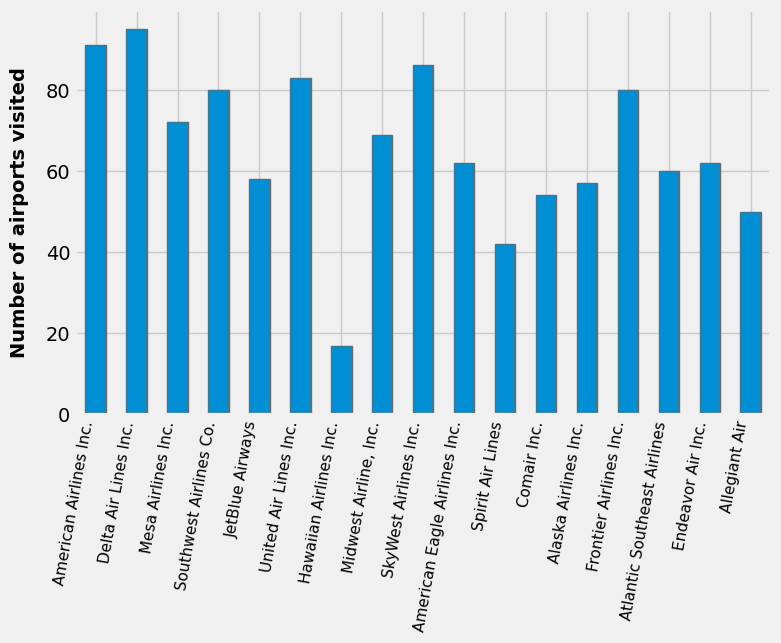

In [55]:
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,5))
labels = [company for company in companies]
ax.set_xticklabels(labels)
plt.ylabel('Number of airports visited', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

How the origin airport impact delays

Essayons de voir les variations des retards par rapport à l'aéroport d'origine et pour chaque compagnie aérienne. La première étape consiste donc à déterminer les retards moyens par aéroport.

In [56]:
# creons un dictionnaire de "DISPLAY_AIRPORT_NAME", pour facilement identifier la ville d'origine .
identify_airport = airports.set_index('DISPLAY_AIRPORT_NAME')['ORIGIN_CITY_NAME'].to_dict()

airport_mean_delays = pd.DataFrame(pd.Series(sampled_df['ORIGIN'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in companies:
    df1 = sampled_df[sampled_df['CARRIER_NAME'] == carrier]
    test = df1['DEP_DELAY_NEW'].groupby(sampled_df['ORIGIN']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean'] 

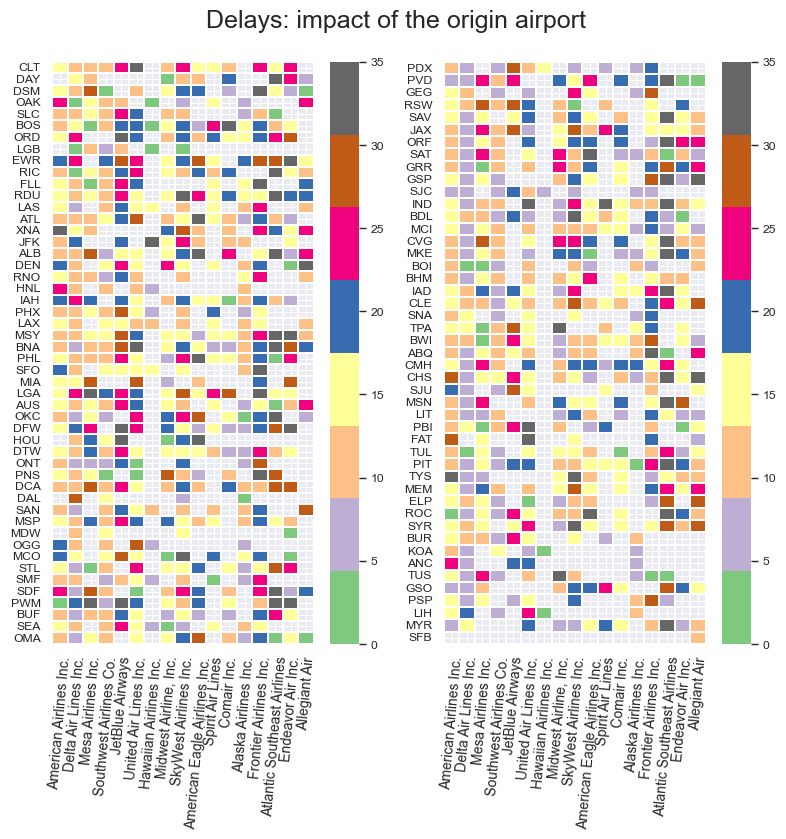

In [57]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(8,8))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:]
subset = subset.rename(index = identify_airport)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85)
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[50:100,:]
subset = subset.rename(index = identify_airport)
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85)
ax.yaxis.label.set_visible(False)

plt.tight_layout()

Comme on peut le constater, la ville a une grande influence sur les retards

# MODELISATION
    Avec toutes les données qu'on a à disposition, nous avons la capacité de predire s'il y'aura du retard d'un vol à l'arrivée ou depart, et ceci en fonction des differents parmètres une ville spécifique d'arrivéé ou de départ, une compagnie spécifique, un aéroport spécifique d'arrivée ou départ, le jour ou encore le mois de départ etc...
    mais nous n'allons pas trop nous étendre sur ces différentes optiions sinon cela créera un schema trop long, c'est pour cela qui nous allons prédire un retard ou nous sur les départs uniquements sur l'ensemble du jeu.

In [58]:
# unique_carrier = input('Insérer le code carrier: ')

# carrier_df = sampled_df[sampled_df['OP_UNIQUE_CARRIER'] == str(unique_carrier).upper()]

In [59]:
# We collect only the columns that will be used

sampled_df = sampled_df[['MONTH', 'CARRIER_NAME', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY_NEW', 'ARR_TIME',  'ARR_DELAY_NEW', 'CRS_ARR_TIME' , 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME']]
sampled_df.head(3)

,MONTH,CARRIER_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,ARR_TIME,ARR_DELAY_NEW,CRS_ARR_TIME,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME
2313100,1,American Airlines Inc.,65700,65340,0.0,69060,0.0,70020,132.0,122.0
7165221,1,Delta Air Lines Inc.,21600,21120,0.0,28920,16.0,27960,106.0,130.0
5790417,1,Mesa Airlines Inc.,22500,22080,0.0,31440,0.0,32100,160.0,156.0


In [60]:
# Creation d'un nouveau et ajout d'une colonne d'indicateur de retard qui sera notre variable cible
sampled_df_new = sampled_df.copy()
sampled_df_new["DELAYED"] = (sampled_df_new["DEP_DELAY_NEW"] > 0).astype(int)
sampled_df_new = sampled_df_new.drop(['DEP_DELAY_NEW'], axis=1)
sampled_df_new.head(3)

,MONTH,CARRIER_NAME,CRS_DEP_TIME,DEP_TIME,ARR_TIME,ARR_DELAY_NEW,CRS_ARR_TIME,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DELAYED
2313100,1,American Airlines Inc.,65700,65340,69060,0.0,70020,132.0,122.0,0
7165221,1,Delta Air Lines Inc.,21600,21120,28920,16.0,27960,106.0,130.0,0
5790417,1,Mesa Airlines Inc.,22500,22080,31440,0.0,32100,160.0,156.0,0


    # PREDICTION DE VOL RETARDE OU PAS

In [61]:
# Separate target variable Y from features X
print("Separating labels from features...")
target_variable = "DELAYED"

X = sampled_df_new.drop(target_variable, axis = 1)
Y = sampled_df_new[target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
2313100    0
7165221    0
5790417    0
1970586    1
1268149    0
Name: DELAYED, dtype: int32

X :
         MONTH            CARRIER_NAME  CRS_DEP_TIME  DEP_TIME  ARR_TIME   
2313100      1  American Airlines Inc.         65700     65340     69060  \
7165221      1    Delta Air Lines Inc.         21600     21120     28920   
5790417      1      Mesa Airlines Inc.         22500     22080     31440   
1970586      1  Southwest Airlines Co.         35700     36000     64740   
1268149      1    Delta Air Lines Inc.         30000     29940     31320   

         ARR_DELAY_NEW  CRS_ARR_TIME  CRS_ELAPSED_TIME  ACTUAL_ELAPSED_TIME  
2313100            0.0         70020             132.0                122.0  
7165221           16.0         27960             106.0                130.0  
5790417            0.0         32100             160.0                156.0  
1970586            0.0         64800             305.0                299.0  
12681

In [62]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []

for nom_colonne, dtype in X.dtypes.items():
    if ('float' in str(dtype)) or ('int' in str(dtype)):
        numeric_features.append(nom_colonne)
    else:
        categorical_features.append(nom_colonne)

print('numeric features detected : ', numeric_features)
print('categorical features détected : ', categorical_features)

numeric features detected :  ['MONTH', 'CRS_DEP_TIME', 'DEP_TIME', 'ARR_TIME', 'ARR_DELAY_NEW', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME']
categorical features détected :  ['CARRIER_NAME']


In [63]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
# WARNING : don't forget stratify=Y for classification problems
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



PREPROCESSING

In [64]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = OneHotEncoder(drop='first') # no missing values in categorical data, so we only need the OHE

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [65]:

# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()
# Label encoding
print("Encoding labels...")
print(Y_train.head())
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("...Done")
print(Y_train[0:5])

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()
# Label encoding
print("Encoding labels...")
print(Y_test[0:5])
Y_test = encoder.transform(Y_test)
print("...Done")
print(Y_test[0:5])

Performing preprocessings on train set...
         MONTH            CARRIER_NAME  CRS_DEP_TIME  DEP_TIME  ARR_TIME   
5759709     10      Mesa Airlines Inc.         56700     69300     76440  \
7072215      3  Southwest Airlines Co.         38400     38340     42060   
2793749     12  Southwest Airlines Co.         70500     71340     75600   
3686264      8   United Air Lines Inc.         81000     80940       900   
3177175      2  Frontier Airlines Inc.         27720     27720     33900   

         ARR_DELAY_NEW  CRS_ARR_TIME  CRS_ELAPSED_TIME  ACTUAL_ELAPSED_TIME  
5759709          229.0         62700             160.0                179.0  
7072215            0.0         42300              65.0                 62.0  
2793749            5.0         75300              80.0                 71.0  
3686264            5.0           600             100.0                106.0  
3177175            0.0         34140             107.0                103.0  
...Done.
[[ 1.09917878  0.4598220

A. TRAIN MODEL ON MULTIPLE LOGISTICAL REGRESSION 

In [66]:
# Train model
print("Train model...")
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


Perfomance Assessment

In [67]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = classifier.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()

Predictions on training set...
...Done.
[1 0 1 ... 0 1 1]

Probabilities on training set...
...Done.
[[0.00000000e+00 1.00000000e+00]
 [8.31564604e-01 1.68435396e-01]
 [3.38084095e-01 6.61915905e-01]
 ...
 [8.56627736e-01 1.43372264e-01]
 [1.01028347e-05 9.99989897e-01]
 [3.33699235e-01 6.66300765e-01]]



In [68]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = classifier.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()

Predictions on test set...
...Done.
[0 1 0 ... 0 0 1]

Probabilities on test set...
...Done.
[[9.52094324e-01 4.79056755e-02]
 [1.16505652e-03 9.98834943e-01]
 [9.51013842e-01 4.89861581e-02]
 ...
 [8.00139690e-01 1.99860310e-01]
 [9.25131730e-01 7.48682696e-02]
 [3.56603636e-13 1.00000000e+00]]



In [69]:
# Print scores
from sklearn.metrics import f1_score, precision_score, recall_score


print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

print("Precision on training set : ", precision_score(Y_train, Y_train_pred))
print("Precision on test set : ", precision_score(Y_test, Y_test_pred))
print()

print("Recall on training set : ", recall_score(Y_train, Y_train_pred))
print("Recall on test set : ", recall_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.8258271705603807
accuracy on test set :  0.8249923139645239

f1-score on training set :  0.7176230929264911
f1-score on test set :  0.716363912087436

Precision on training set :  0.8679265064346185
Precision on test set :  0.865990990990991

Recall on training set :  0.6116929897478526
Recall on test set :  0.6108247898771589



In [70]:
# the average score with a cross-validation using K-fold=10

scores = cross_val_score(classifier,X_train, Y_train, cv=10)
avg = scores.mean()


c:\Users\galus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

c:\Users\galus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

In [71]:
print('Cross-validated accuracy : {}'.format(avg))

Cross-validated accuracy : 0.8258706165629788


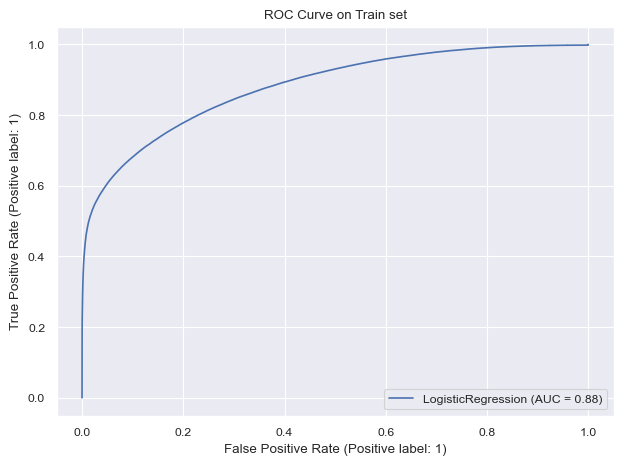

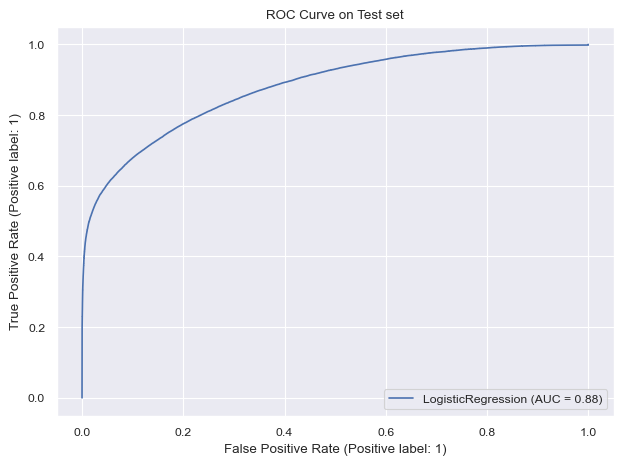

In [72]:
# Visualize ROC curves
from sklearn.metrics import RocCurveDisplay


_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Train set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(classifier, X_train, Y_train, ax=ax) # RocCurveDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Test set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(classifier, X_test, Y_test, ax=ax) # RocCurveDisplay from sklearn
plt.show()

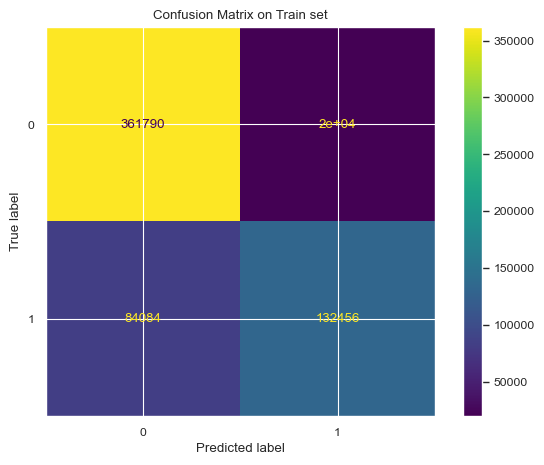

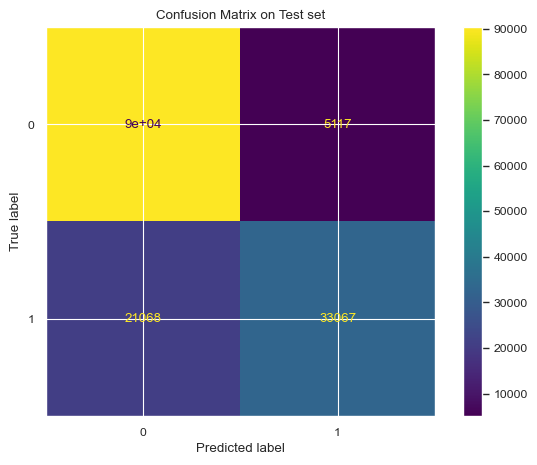

In [73]:
# Visualize confusion matrices
from sklearn.metrics import ConfusionMatrixDisplay


_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(classifier, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

B. TRAIN MODEL ON RANDOM FOREST


In [74]:
# Perform grid search
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


print("Grid search...")
rf = RandomForestClassifier()

# Grid of values to be tested
params = {
    'max_depth': [6],
    'min_samples_leaf': [1],
    'min_samples_split': [8],
    'n_estimators': [50, 100]
}
gridsearch = GridSearchCV(rf, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")



Grid search...
...Done.


In [75]:
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Best hyperparameters :  {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 100}
Best validation accuracy :  0.8173507811378199


In [76]:
# Définir les valeurs des hyperparamètres
max_depth = 6  # la profondeur maximale de chaque arbre dans la forêt
min_samples_leaf = 1  # le nombre minimum d'échantillons requis pour être une feuille de l'arbre
min_samples_split = 8 # le nombre minimum d'échantillons requis pour diviser un nœud
n_estimators = 50   # le nombre d'arbres dans la forêt

# Créer le modèle de forêt aléatoire avec les hyperparamètres choisis
rf_model = RandomForestClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, n_estimators=n_estimators)

# Entraîner le modèle sur les données d'entraînement
rf_model.fit(X_train, Y_train)

# Faire des prédictions sur les données de test
Y_pred = rf_model.predict(X_test)


Perfomances

In [77]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = rf_model.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = rf_model.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()

Predictions on training set...
...Done.
[1 0 1 ... 0 1 0]

Probabilities on training set...
...Done.
[[0.23091403 0.76908597]
 [0.76714582 0.23285418]
 [0.24779347 0.75220653]
 ...
 [0.50538256 0.49461744]
 [0.19460914 0.80539086]
 [0.72275077 0.27724923]]



In [78]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = rf_model.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = rf_model.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()

Predictions on test set...
...Done.
[0 1 0 ... 0 0 1]

Probabilities on test set...
...Done.
[[0.87823968 0.12176032]
 [0.26898477 0.73101523]
 [0.77479822 0.22520178]
 ...
 [0.88374532 0.11625468]
 [0.75510402 0.24489598]
 [0.23710346 0.76289654]]



In [79]:
# Print scores
from sklearn.metrics import f1_score, precision_score, recall_score


print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

print("Precision on training set : ", precision_score(Y_train, Y_train_pred))
print("Precision on test set : ", precision_score(Y_test, Y_test_pred))
print()

print("Recall on training set : ", recall_score(Y_train, Y_train_pred))
print("Recall on test set : ", recall_score(Y_test, Y_test_pred))
print()

accuracy on training set :  0.8172538706001478
accuracy on test set :  0.8181550841453797

f1-score on training set :  0.7156484233022128
f1-score on test set :  0.7169253818302884

Precision on training set :  0.8187788902571791
Precision on test set :  0.8207046044639241

Recall on training set :  0.6355915766140205
Recall on test set :  0.6364459222314583



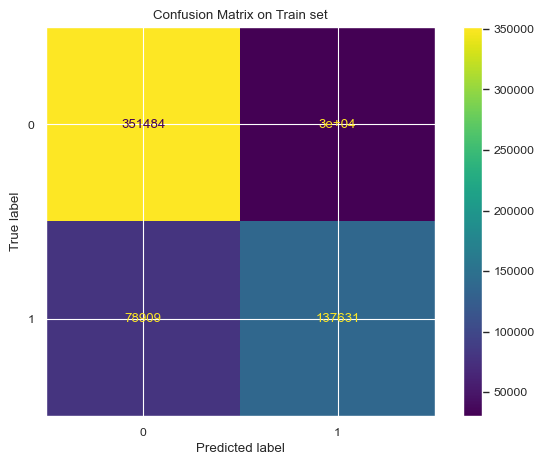

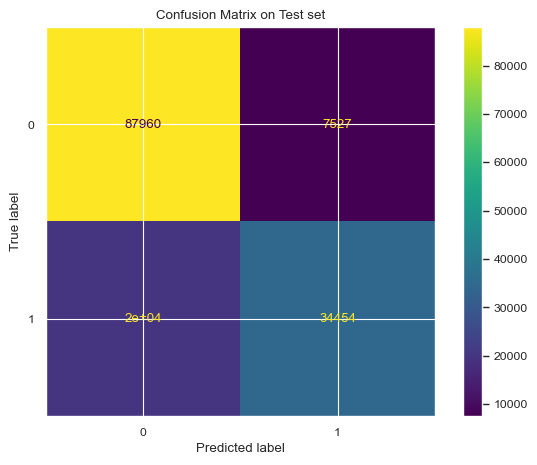

In [80]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(rf_model, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

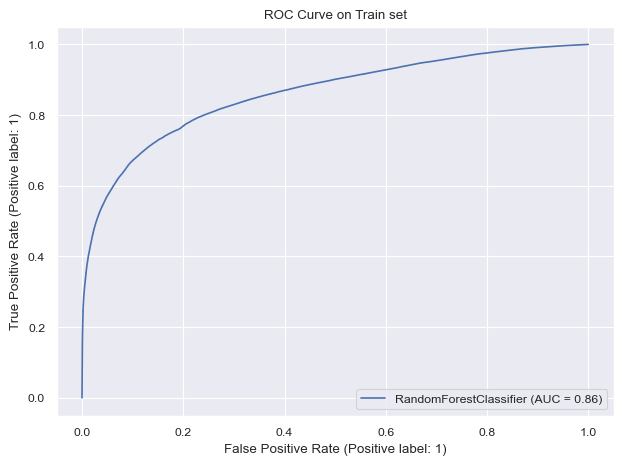

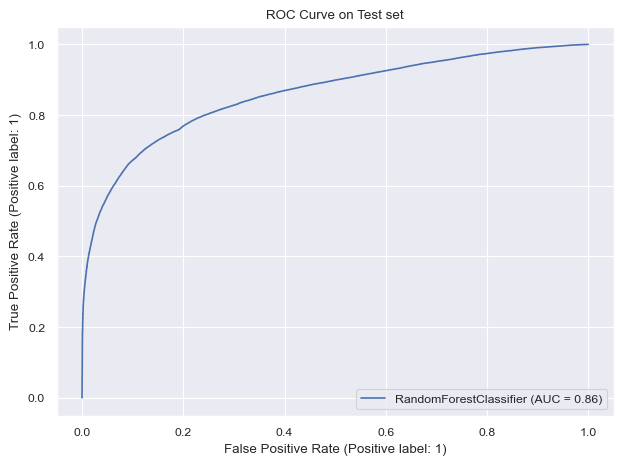

In [81]:
# Visualize ROC curves
from sklearn.metrics import RocCurveDisplay


_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Train set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(rf_model, X_train, Y_train, ax=ax) # RocCurveDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Test set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(rf_model, X_test, Y_test, ax=ax) # RocCurveDisplay from sklearn
plt.show()

Feature importance

In [82]:
column_names = []
for name, step, features_list in preprocessor.transformers_: # loop over steps of ColumnTransformer
    if name == 'num': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = step.get_feature_names_out() # get output columns names from OneHotEncoder
    column_names.extend(features) # concatenate features names
        
print("Names of columns corresponding to each coefficient: ", column_names)

Names of columns corresponding to each coefficient:  ['MONTH', 'CRS_DEP_TIME', 'DEP_TIME', 'ARR_TIME', 'ARR_DELAY_NEW', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'CARRIER_NAME_Allegiant Air', 'CARRIER_NAME_American Airlines Inc.', 'CARRIER_NAME_American Eagle Airlines Inc.', 'CARRIER_NAME_Atlantic Southeast Airlines', 'CARRIER_NAME_Comair Inc.', 'CARRIER_NAME_Delta Air Lines Inc.', 'CARRIER_NAME_Endeavor Air Inc.', 'CARRIER_NAME_Frontier Airlines Inc.', 'CARRIER_NAME_Hawaiian Airlines Inc.', 'CARRIER_NAME_JetBlue Airways', 'CARRIER_NAME_Mesa Airlines Inc.', 'CARRIER_NAME_Midwest Airline, Inc.', 'CARRIER_NAME_SkyWest Airlines Inc.', 'CARRIER_NAME_Southwest Airlines Co.', 'CARRIER_NAME_Spirit Air Lines', 'CARRIER_NAME_United Air Lines Inc.']


In [83]:
# Create a pandas DataFrame
feature_importance = pd.DataFrame(index = column_names, data = gridsearch.best_estimator_.feature_importances_, columns=["feature_importances"])
feature_importance = feature_importance.sort_values(by = 'feature_importances')

In [84]:
# Plot coefficients
fig = px.bar(feature_importance, orientation = 'h')
fig.update_layout(showlegend = False, 
                  margin = {'l': 120} # to avoid cropping of column names
                 )
fig.show()

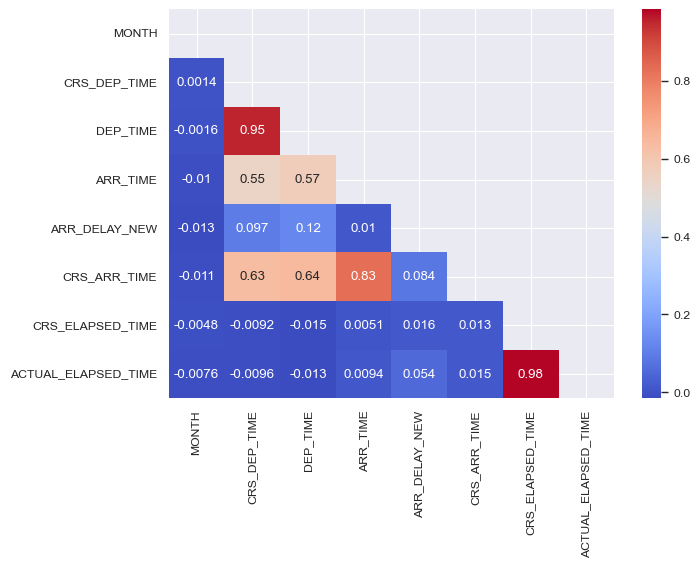

In [85]:
# Supprimer les fonctionnalités qui ont une corrélation faible avec la variable cible ou qui ont des valeurs manquantes élevées
corr_matrix = sampled_df[numeric_features].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_matrix = corr_matrix.mask(mask)
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.show()

# df = df.drop(['SOME_LOW_CORRELATED_FEATURE', 'SOME_FEATURE_WITH_HIGH_MISSING_VALUES'], axis=1)


ON CONSTATE PAR LES RESULTATS DES DEUX MODELES PRECEDENT QUE CELUI DE LA REGRESSION LOGISTIQUE PERFOME MIEUX, NOUS ALLONS DONC LE CHOISIR POUR LA SUITE DU PROJET

    # PREDICTION DELAI MOYEN DE RETARD SI RETARD

In [86]:
sampled_df.head(5)

,MONTH,CARRIER_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,ARR_TIME,ARR_DELAY_NEW,CRS_ARR_TIME,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME
2313100,1,American Airlines Inc.,65700,65340,0.0,69060,0.0,70020,132.0,122.0
7165221,1,Delta Air Lines Inc.,21600,21120,0.0,28920,16.0,27960,106.0,130.0
5790417,1,Mesa Airlines Inc.,22500,22080,0.0,31440,0.0,32100,160.0,156.0
1970586,1,Southwest Airlines Co.,35700,36000,5.0,64740,0.0,64800,305.0,299.0
1268149,1,Delta Air Lines Inc.,30000,29940,0.0,31320,0.0,32700,105.0,83.0


In [87]:
# Separate target variable Y from features X
print("Separating labels from features...")
target_variable = "DEP_DELAY_NEW"

X = sampled_df.drop(target_variable, axis = 1)
Y = sampled_df[target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
2313100    0.0
7165221    0.0
5790417    0.0
1970586    5.0
1268149    0.0
Name: DEP_DELAY_NEW, dtype: float64

X :
         MONTH            CARRIER_NAME  CRS_DEP_TIME  DEP_TIME  ARR_TIME   
2313100      1  American Airlines Inc.         65700     65340     69060  \
7165221      1    Delta Air Lines Inc.         21600     21120     28920   
5790417      1      Mesa Airlines Inc.         22500     22080     31440   
1970586      1  Southwest Airlines Co.         35700     36000     64740   
1268149      1    Delta Air Lines Inc.         30000     29940     31320   

         ARR_DELAY_NEW  CRS_ARR_TIME  CRS_ELAPSED_TIME  ACTUAL_ELAPSED_TIME  
2313100            0.0         70020             132.0                122.0  
7165221           16.0         27960             106.0                130.0  
5790417            0.0         32100             160.0                156.0  
1970586            0.0         64800             305.0           

In [88]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []

for nom_colonne, dtype in X.dtypes.items():
    if ('float' in str(dtype)) or ('int' in str(dtype)):
        numeric_features.append(nom_colonne)
    else:
        categorical_features.append(nom_colonne)

print('numeric features detected : ', numeric_features)
print('categorical features détected : ', categorical_features)

numeric features detected :  ['MONTH', 'CRS_DEP_TIME', 'DEP_TIME', 'ARR_TIME', 'ARR_DELAY_NEW', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME']
categorical features détected :  ['CARRIER_NAME']


In [89]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



PREPROCESSING

In [90]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = OneHotEncoder(drop='first') # no missing values in categorical data, so we only need the OHE

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [91]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()


# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head())
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()

Performing preprocessings on train set...
         MONTH            CARRIER_NAME  CRS_DEP_TIME  DEP_TIME  ARR_TIME   
2302009      6    Delta Air Lines Inc.         73800     73320     77880  \
2843778      5   United Air Lines Inc.         63300     62760     80400   
7086552      7  Southwest Airlines Co.         49200     49140     53760   
4499771      4  American Airlines Inc.         24600     27960     48240   
1848439      2  Frontier Airlines Inc.         68760     68400     77580   

         ARR_DELAY_NEW  CRS_ARR_TIME  CRS_ELAPSED_TIME  ACTUAL_ELAPSED_TIME  
2302009            0.0         79080             148.0                136.0  
2843778            0.0         81240             179.0                174.0  
7086552            0.0         54300              85.0                 77.0  
4499771           54.0         45000             220.0                218.0  
1848439            0.0         78720             166.0                153.0  
...Done.
[[-0.17651551  1.4135059

TRAIN MODEL

In [92]:
# Train model
print("Train model...")
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


PERFOMANCE ASSESSMENT

In [93]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = regressor.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()


# Predictions on test set
print("Predictions on test set...")
Y_test_pred = regressor.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[  3.5892437   -0.28598416   2.09545589 ...  -2.16022362 117.23856307
  -5.43885288]

Predictions on test set...
...Done.
[  1.94798371 204.22121731   4.54155621 ...  70.349833     1.49349426
  -2.28391066]



In [94]:
# Print scores
from sklearn.metrics import f1_score, precision_score, recall_score

print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

print("MAE : ", mean_absolute_error(Y_test, Y_test_pred))
print()


print("MSE : ", mean_squared_error(Y_test, Y_test_pred))
print()

print("RMSE : ", np.sqrt(mean_squared_error(Y_test, Y_test_pred)))
print()


R2 score on training set :  0.9830521751065127
R2 score on test set :  0.9833242074562926
MAE :  4.586005692469139

MSE :  36.27588576200044

RMSE :  6.022946601290804



Interpreting the model's coefficients

In [95]:
regressor.coef_

array([-3.66654094e-02, -2.51006463e-01,  7.92215468e-01, -2.43085865e-01,
        4.71034251e+01,  1.13493507e-01,  4.48040164e+01, -4.55420732e+01,
        5.28730122e-01, -6.17741752e-01, -9.95957132e-01, -7.45454612e-01,
       -4.24392003e-01, -1.31013379e+00, -2.48031515e+00, -1.84704368e-01,
        1.39340864e+00, -7.19091469e-01, -5.35677486e-01, -1.44505390e+00,
       -1.16850393e+00, -3.77972593e-01, -5.56709695e-01, -3.65221809e-01])

In [96]:
column_names = []
for name, pipeline, features_list in preprocessor.transformers_: # loop over pipelines
    if name == 'num': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = pipeline.get_feature_names_out()
    column_names.extend(features) # concatenate features names
        
print("Names of columns corresponding to each coefficient: ", column_names)

Names of columns corresponding to each coefficient:  ['MONTH', 'CRS_DEP_TIME', 'DEP_TIME', 'ARR_TIME', 'ARR_DELAY_NEW', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'CARRIER_NAME_Allegiant Air', 'CARRIER_NAME_American Airlines Inc.', 'CARRIER_NAME_American Eagle Airlines Inc.', 'CARRIER_NAME_Atlantic Southeast Airlines', 'CARRIER_NAME_Comair Inc.', 'CARRIER_NAME_Delta Air Lines Inc.', 'CARRIER_NAME_Endeavor Air Inc.', 'CARRIER_NAME_Frontier Airlines Inc.', 'CARRIER_NAME_Hawaiian Airlines Inc.', 'CARRIER_NAME_JetBlue Airways', 'CARRIER_NAME_Mesa Airlines Inc.', 'CARRIER_NAME_Midwest Airline, Inc.', 'CARRIER_NAME_SkyWest Airlines Inc.', 'CARRIER_NAME_Southwest Airlines Co.', 'CARRIER_NAME_Spirit Air Lines', 'CARRIER_NAME_United Air Lines Inc.']


In [97]:
# Create a pandas DataFrame
coefs = pd.DataFrame(index = column_names, data = regressor.coef_.transpose(), columns=["coefficients"])
coefs

,coefficients
MONTH,-0.036665
CRS_DEP_TIME,-0.251006
DEP_TIME,0.792215
ARR_TIME,-0.243086
ARR_DELAY_NEW,47.103425
CRS_ARR_TIME,0.113494
CRS_ELAPSED_TIME,44.804016
ACTUAL_ELAPSED_TIME,-45.542073
CARRIER_NAME_Allegiant Air,0.528730
CARRIER_NAME_American Airlines Inc.,-0.617742


In [98]:
# Plot coefficients
fig = px.bar(feature_importance, orientation = 'h')
fig.update_layout(showlegend = False, 
                  margin = {'l': 120} # to avoid cropping of column names
                 )
fig.show()

Les résultats indiquent que notre modèle de régression logistique multiple est très performant. Le R2 score est proche de 1 sur les deux ensembles d'entraînement et de test, ce qui signifie que le modèle explique la grande majorité de la variance dans les données. La MAE (Mean Absolute Error) est relativement faible, ce qui indique que les prédictions du modèle sont en moyenne proches des valeurs réelles de la variable cible. De même, la RMSE (Root Mean Squared Error) est également faible, ce qui suggère que le modèle ne présente pas de grosses erreurs dans ses prédictions.

# DEPLOIEMENT DES MODELES SUR LE GRAND JEU DE DONNEES DF

1. Reg Logistic Pour predire s'il y'a retard ou pas.

In [129]:
used_columns = ['MONTH', 'CARRIER_NAME', 'CRS_DEP_TIME', 'DEP_TIME', 'ARR_TIME',  'ARR_DELAY_NEW', 'CRS_ARR_TIME' , 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME']
used_columns_rlin = ['MONTH', 'CARRIER_NAME', 'CRS_DEP_TIME', 'DEP_TIME', 'ARR_TIME',  'ARR_DELAY_NEW', 'CRS_ARR_TIME' , 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'DEP_DELAY_NEW']
used_columns_rlog = ['MONTH', 'CARRIER_NAME', 'CRS_DEP_TIME', 'DEP_TIME', 'ARR_TIME',  'ARR_DELAY_NEW', 'CRS_ARR_TIME' , 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'DELAYED']

In [130]:
# Creation d'un nouveau df et ajout d'une colonne d'indicateur de retard qui sera notre variable cible sur le grand dataset
df["DELAYED"] = (df["DEP_DELAY_NEW"] > 0).astype(int)
rlog_df = df.copy()
rlog_df = rlog_df[used_columns_rlog]
rlog_df.dropna(inplace=True)
rlog_df.head(2)

,MONTH,CARRIER_NAME,CRS_DEP_TIME,DEP_TIME,ARR_TIME,ARR_DELAY_NEW,CRS_ARR_TIME,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DELAYED
0,1,Endeavor Air Inc.,1000,955.0,1110.0,1.0,1109,129.0,135.0,0
1,1,Endeavor Air Inc.,1722,1712.0,1809.0,0.0,1830,128.0,117.0,0


Preprocessing

In [131]:
# Séparer les données en entrées X et cible Y
print("Separating labels from features...")

target_variable = "DELAYED"
X = rlog_df[used_columns]
Y = rlog_df[target_variable]

# Créer une instance de la classe OneHotEncoder pour encoder CARRIER_NAME

ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X[['CARRIER_NAME']])
carrier_encoded = ohe.transform(X[['CARRIER_NAME']]).toarray()
X = np.concatenate((X.drop('CARRIER_NAME', axis=1), carrier_encoded), axis=1)

print('Done...')

Separating labels from features...
Done...


In [132]:
print()
(X[0:5,:])
print()
print(Y.head(5))



0    0
1    0
2    0
3    1
4    0
Name: DELAYED, dtype: int32


Train model

In [133]:
# Entraîner votre modèle sur l'ensemble des données
print('Training model...')
classifier.fit(X, Y)
print('Done...')


Training model...
Done...


c:\Users\galus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [134]:
# Prédire les valeurs de la cible pour l'ensemble des données
print('Predicting target...')
Y_pred = classifier.predict(X)
print('Done...')
print()
print(Y_pred[0:5])

Predicting target...
Done...

[0 0 1 1 0]


In [135]:
# Print scores
from sklearn.metrics import f1_score, precision_score, recall_score


print("accuracy : ", accuracy_score(Y, Y_pred))
print()

print("f1-score: ", f1_score(Y, Y_pred))
print()

print("Precision: ", precision_score(Y, Y_pred))
print()

print("Recall: ", recall_score(Y, Y_pred))
print()

accuracy on training set :  0.812712568097983

f1-score on training set :  0.6933672868672394

Precision on training set :  0.8476351101888723

Recall on training set :  0.5866061840399925



Nous constatons qu'apres l'application du model sur le grand dataset, les metriques sont presque similaires, ce qui veut ce model s'est bien généralisé sur l'ensemble ded données.

2. Reg Lineaie multiple pour predire le temps de retard en cas de retard.

In [136]:
# Creation d'un nouveau df et ajout d'une colonne d'indicateur de retard qui sera notre variable cible sur le grand dataset
rlin_df = df.copy()
rlin_df = rlin_df[used_columns_rlin]
rlin_df.dropna(inplace=True)
rlin_df.head(2)

,MONTH,CARRIER_NAME,CRS_DEP_TIME,DEP_TIME,ARR_TIME,ARR_DELAY_NEW,CRS_ARR_TIME,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DEP_DELAY_NEW
0,1,Endeavor Air Inc.,1000,955.0,1110.0,1.0,1109,129.0,135.0,0.0
1,1,Endeavor Air Inc.,1722,1712.0,1809.0,0.0,1830,128.0,117.0,0.0


In [137]:
# Séparer les données en entrées X et cible Y
print("Separating labels from features...")

target_variable = "DEP_DELAY_NEW"
X = rlin_df[used_columns]
Y = rlin_df[target_variable]

# Créer une instance de la classe OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X[['CARRIER_NAME']])
carrier_encoded = ohe.transform(X[['CARRIER_NAME']]).toarray()
X = np.concatenate((X.drop('CARRIER_NAME', axis=1), carrier_encoded), axis=1)

print('Done...')

Separating labels from features...
Done...


In [138]:
print()
(X[0:5,:])
print()
print(Y.head(5))



0      0.0
1      0.0
2      0.0
3    112.0
4      0.0
Name: DEP_DELAY_NEW, dtype: float64


In [140]:
# Entraîner votre modèle sur l'ensemble des données
print('Training model...')
regressor.fit(X, Y)
print('Done...')

Training model...
Done...


In [141]:
# Prédire les valeurs de la cible pour l'ensemble des données
print('Predicting target...')
Y_pred = regressor.predict(X)
print('Done...')
print()
print(Y_pred[0:5])

Predicting target...
Done...

[ -8.22822652   1.73612816  10.23926861 100.70319583   5.72685381]


In [143]:
# Print scores

r2 = r2_score(Y, Y_pred)
mae = mean_absolute_error(Y, Y_pred)
mse = mean_squared_error(Y_test, Y_test_pred)
rmse = np.sqrt(mse)

print("R2 score: ", r2)
print()
print("MAE : ", mae)
print()

print("MSE : ", mse)
print()

print("RMSE : ", rmse)


R2 score:  0.9832617283916705

MAE :  4.607614614649519

MSE :  36.27588576200044

RMSE :  6.022946601290804


Nous constatons qu'apres l'application du model de regression pour predire le temps de retard sur le grand dataset, les metriques sont egalement presque similaires que sur le petit jeu de données, ce qui veut que ce model s'est également bien généralisé sur l'ensemble de données.

# ENREGISTREMENT DE NOS MODELES

In [146]:
import pickle

# Enregistrer le modèle avec Pickle

print('Saving model...')
with open('./ml_models/classifier.pkl', 'wb') as f:
    pickle.dump(classifier, f)
print('Model saved!...')


Saving model...
Model saved!...


In [147]:
print('Saving model...')
with open('./ml_models/regressor.pkl', 'wb') as f:
    pickle.dump(regressor, f)
print('Model saved!...')

Saving model...
Model saved!...
